# Autograd: automatic differentiation

When executing tensor operations, PyTorch can automatically construct on-the-fly the graph of operations to compute the gradient of any quantity with respect to any tensor involved.

More information on autotomatic differentiation in Pytorch [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

## Visualizing the computational graph

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

PyTorchViz is a small package to create visualizations of PyTorch execution graphs and traces.

In [2]:
!pip install torchviz


     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=117e068aed9906cd0b9af6ef34c8ac491a34b803c61b765116ef34fe11df1117
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [1]:
import torchviz

Inn order to enable automatic differentiation, PyTorch keeps track of all operations involving tensors for which the gradient may need to be computed (i.e., require_grad is True). The operations are recorded as a directed graph. 

Torch tensors are recalled [here](https://pytorch.org/docs/stable/tensors.html) 



In [4]:
x = torch.ones(2, 2)
print(x)

tensor([[1., 1.],
        [1., 1.]])


A Tensor has a Boolean field *requires_grad*, set to False by default, which states if PyTorch should build the graph of operations so that gradients wrt to it can be computed.

In [5]:
x.requires_grad

False

In [6]:
x.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [7]:
x.requires_grad_(True)
x.requires_grad

True

### Question: The following cell gives an error. Why?

Because the structure is more complex now

In [8]:
x.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

The detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded.

In [9]:
x.detach().numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [10]:
x.data.numpy() # Torch.data returns the "data" (array_like) stored in the tensor

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [11]:
x.requires_grad

True

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


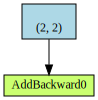

In [12]:
y = x + 2
print(y)
torchviz.make_dot(y)

**Broadcasting**

Recall: Broadcasting **automatically** expands dimensions by replicating coefficients, when it is necessary to perform operations.

1. If one of the tensors has fewer dimensions than the other, it is reshaped by adding as many dimensions of size 1 as necessary in the front; then
2. for every mismatch, if one of the two tensor is of size one, it is expanded along this axis by replicating  coefficients.

If there is a tensor size mismatch for one of the dimension and neither of them is one, the operation fails.

In [12]:
A = torch.tensor([[1.], [2.], [3.], [4.]])
print(A.size())
print(A)
B = torch.tensor([[5., -5., 5., -5., 5.]])
print(B.size())
print(B)
C = A + B
print(C)

torch.Size([4, 1])
tensor([[1.],
        [2.],
        [3.],
        [4.]])
torch.Size([1, 5])
tensor([[ 5., -5.,  5., -5.,  5.]])
tensor([[ 6., -4.,  6., -4.,  6.],
        [ 7., -3.,  7., -3.,  7.],
        [ 8., -2.,  8., -2.,  8.],
        [ 9., -1.,  9., -1.,  9.]])


Back to Autograd!

In [16]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [17]:
y.requires_grad

True

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. 

Each tensor has a .grad_fn attribute that references a Function that has created the Tensor (except for Tensors created by the user - their grad_fn is None).

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


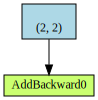

In [13]:
print(x)
print(x.grad_fn)
print(y)
print(y.grad_fn)
torchviz.make_dot(y) 

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)


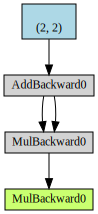

In [14]:
z = y * y * 3
print(z)
torchviz.make_dot(z) 

tensor(27., grad_fn=<MeanBackward0>)


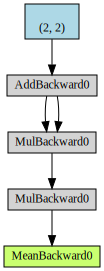

In [15]:
out = z.mean()
print(out)
torchviz.make_dot(out) 

After the computation is finished, i.e. _forward pass_, you can call ```.backward()``` and have all the gradients computed automatically.

In [16]:
out.backward()

The gradients w.r.t. this variable is accumulated into ```.grad```.

In [17]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### Question: Explain mathematically the value of "x.grad"


[Why can I not see .grad of an intermediate variable?](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94)

Gradients are only retained for leaf variables. 

Non-leaf variables’ gradients are not retained to be inspected later. This was done by design, to save memory.

In [18]:
print(y.grad)
print(out.grad)

None
None


<ipython-input-18-e6d0027315c4>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(y.grad)
<ipython-input-18-e6d0027315c4>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(out.grad)


tensor([[2., 2.],
        [2., 2.]])
tensor(10., grad_fn=<MeanBackward0>)


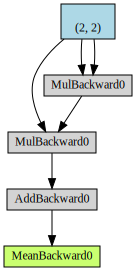

In [23]:
x = 2 * torch.ones(2, 2)
print(x)
x.requires_grad_(True)
out = (x * x * x + 2 ).mean()
print(out)
torchviz.make_dot(out)

In [27]:
#out.backward(torch.tensor(2.0))
out.backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

### Question: Explain mathematically the value of "x.grad" in the following cell

In [26]:
print(x.grad)

tensor([[3., 3.],
        [3., 3.]])


## How to compute the gradient when I want?



In [28]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
z = 3 * y ** 2 
out = z.mean()

out.backward(retain_graph=True)

print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Calling again the "backward" process does not launch an error

In [29]:
out.backward(retain_graph=True)

In [30]:
print(x.grad)

tensor([[9., 9.],
        [9., 9.]])


In [31]:
torch.autograd.grad(out, out, retain_graph=True)

(tensor(1.),)

In [32]:
torch.autograd.grad(out, z, retain_graph=True)

(tensor([[0.2500, 0.2500],
         [0.2500, 0.2500]]),)

In [33]:
torch.autograd.grad(out, y, retain_graph=True)

(tensor([[4.5000, 4.5000],
         [4.5000, 4.5000]]),)

In [34]:
out.backward(torch.tensor(2.0), retain_graph=True)

In [35]:
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


## A last example

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])


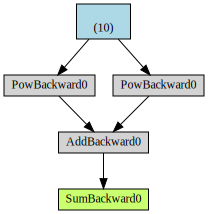

In [36]:
x=torch.ones(10, requires_grad=True)

y=x**2
z=x**3
r=(y+z).sum()

r.backward()
print(x.grad)
torchviz.make_dot(r) 

## Gradient accumulation


The gradients must be set to zero manually. Otherwise they will cumulate across several _.backward()_ calls. 
This accumulating behavior is desirable in particular to compute the gradient of a loss summed over several “mini-batches,” or the gradient of a sum of losses.


In [37]:
x = torch.ones(1, 1,requires_grad = True)
out = (x+1)**2
print(out)

tensor([[4.]], grad_fn=<PowBackward0>)


In [38]:
out.backward(torch.ones(1,1),retain_graph=True)
print(x.grad)
out.backward(2 * torch.ones(1,1),retain_graph=True)
print(x.grad)
out.backward(retain_graph=True)
print(x.grad)

tensor([[4.]])
tensor([[12.]])
tensor([[16.]])


In [39]:
# Manually zero the gradients after updating weights
x.grad.data.zero_()

tensor([[0.]])

In [40]:
out.backward(torch.ones(1,1),retain_graph=True)
print(x.grad)
x.grad.data.zero_()
out.backward(2 * torch.ones(1,1),retain_graph=True)
print(x.grad)
x.grad.data.zero_()
out.backward(retain_graph=True)
print(x.grad)


tensor([[4.]])
tensor([[8.]])
tensor([[4.]])


If you want to come back to the difference between detach and data see [Differences between .data and .detach](https://github.com/pytorch/pytorch/issues/6990)

# Playing with a neural network in pytorch: non-linear regression

## Non-linear regression with a neural network

An implementation of **(Batch) Gradient Descent** using the nn package. Here we have a super simple model with only one layer and no activation function!

Generate the dataset and visualize it.

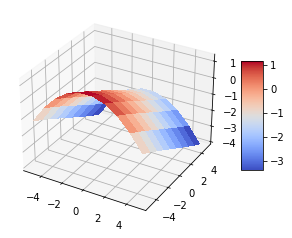

In [43]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


# Make data
num_samples = 10
X1 = np.linspace(-5, 5, num_samples) 
X2 = np.linspace(-5, 5, num_samples) 
X1grid, X2grid = np.meshgrid(X1, X2)
Y = -(0.1*X1grid**2 + 3*np.sin(0.1*X2grid) + 0.1) 

#print(X1grid)
#print(X2grid)
#print(Y)

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1grid, X2grid, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [47]:
x1n = X1grid.ravel().reshape(-1, 1)
x2n = X2grid.ravel().reshape(-1, 1)
xn = np.concatenate((x1n,x2n),axis=1)
yn = Y.ravel().reshape(-1, 1)
#print(xn)
#print(x2n.shape)
print(xn.shape)
print(yn.shape)

# Convert in pytorch tensors
x = torch.from_numpy(xn).float()
y = torch.from_numpy(yn).float()
#print(x)
#print(y)
print(x.shape)

(100, 2)
(100, 1)
torch.Size([100, 2])


## Neural network with full implementation (gradient computation and estimate update)

In [48]:
import torch

dtype = torch.float


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Randomly initialize weights
w1 = torch.randn(D_in, H, dtype=dtype)
w2 = torch.randn(H, D_out,  dtype=dtype)

learning_rate = 1e-6 
for t in range(10001):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    #print(y_pred)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 1000 == 0:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 158917.6875
1000 46.129756927490234
2000 22.830181121826172
3000 15.998091697692871
4000 12.499419212341309
5000 10.349212646484375
6000 9.167381286621094
7000 8.427068710327148
8000 7.903247833251953
9000 7.508272647857666
10000 7.2214274406433105


Compare the first values

In [49]:
print(y[0:5])
print(y_pred[0:5])

tensor([[-1.1617],
        [-0.1741],
        [ 0.5667],
        [ 1.0605],
        [ 1.3074]])
tensor([[-0.7359],
        [-0.1861],
        [ 0.8802],
        [ 1.1261],
        [ 1.2868]])


Plot the approximation in 1D

In [50]:
def plotApproximation(y,y_pred):
  plt.figure(figsize=(6, 4))
  plt.plot(y.detach().numpy(),'b-')
  plt.plot(y_pred.detach().numpy(),'r-*')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Approximation with the neural network')
  plt.show()

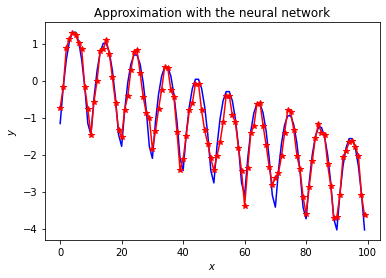

In [51]:
plotApproximation(y,y_pred)

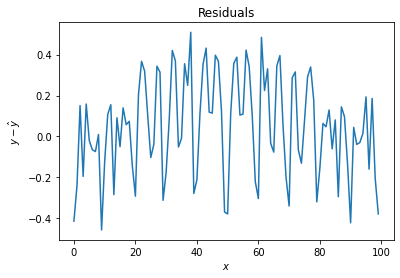

In [44]:
plt.figure(figsize=(6, 4))
plt.plot(y.numpy()-y_pred.numpy())
plt.title('Residuals')
plt.xlabel('$x$')
plt.ylabel('$y-\hat{y}$')
plt.show()

Last step, we use directly the optim package to update the weights and bias.

## Neural network with automatic gradient computation (but still the explicit estimate update)


A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.
PyTorch autograd makes it easy to define computational graphs and take gradients,
but raw autograd can be a bit too low-level for defining complex neural networks;
this is where the nn package can help. The nn package defines a set of Modules,
which you can think of as a neural network layer that has produces output from
input and may have some trainable weights.

### Question: use autograd to compute the gradient. You can start from the full implementation of the neural network.

In [78]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(10001):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())

    
    # COMPLETE THE CODE FROM HERE
    #print('weights before backpropagation = ',   list(model.parameters()))
    loss.backward(retain_graph=True)
    for i in list(model.parameters()):
        i.data -= learning_rate * torch.autograd.grad(loss, i, retain_graph=True)[0]
        i.grad.data.zero_()
  

0 414.96258544921875
1000 15.127250671386719
2000 7.700824737548828
3000 5.506108283996582
4000 4.630465507507324
5000 4.132261753082275
6000 3.7785122394561768
7000 3.502279043197632
8000 3.279761552810669
9000 3.098405361175537
10000 2.949808359146118


In [60]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


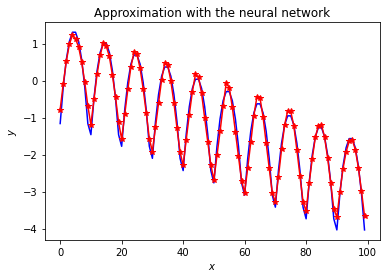

In [79]:
plotApproximation(y,y_pred)

## Neural network with automatic gradient computation and automatic estimate update

A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation uses the nn package from PyTorch to build the network.

Rather than manually updating the weights of the model as we have been doing,
we use the optim package to define an Optimizer that will update the weights
for us. The optim package defines many optimization algorithms that are commonly
used for deep learning, including SGD+momentum, RMSProp, Adam, etc.

### Question: use the Torch optimizer to do the gradient descent. You can start from the full implementation of the neural network with automatic differentiation.

Details on Optimizer are [here](https://pytorch.org/docs/stable/optim.html)

In [83]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = num_samples**2, 2, 100, 1

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-6
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(10001):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print(t, loss.item())

    # COMPLETE THE CODE FROM HERE
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

0 415.0361328125
1000 18.429279327392578
2000 10.580057144165039
3000 8.11782169342041
4000 6.904597282409668
5000 6.078804016113281
6000 5.441740989685059
7000 4.931784629821777
8000 4.519252300262451
9000 4.183667182922363
10000 3.9092795848846436


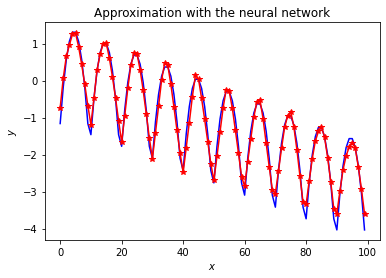

In [84]:
plotApproximation(y,y_pred)